This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


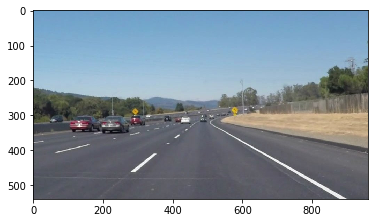

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
# reading in an image
image = cv2.imread('Road_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()

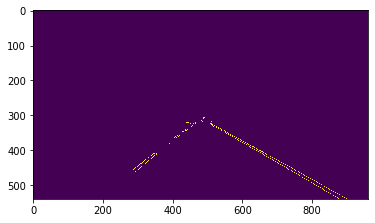

In [19]:
# store the height and width from image
height = image.shape[0]
width = image.shape[1]
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
region_of_interest_vertices = [
    (0, height),
    (width / 2, 300),
    (width, height),
]

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32)
)
plt.figure()
plt.imshow(cropped_image)
plt.show()

In [20]:
# define hough transforms and print detected lines

lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=120,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
print(lines)

[[[483 311 878 539]]

 [[653 402 727 444]]

 [[803 485 898 539]]

 [[629 389 696 427]]

 [[385 382 491 305]]

 [[486 312 829 510]]

 [[390 382 487 304]]

 [[383 380 464 321]]

 [[720 439 815 493]]

 [[307 451 353 410]]

 [[383 382 485 308]]

 [[581 364 627 388]]

 [[280 462 344 410]]]


In [21]:
# define the utility function

def draw_lines(img, lines, color=[250,0 , 0], thickness=9):
    # If there are no lines to draw, exit.
        if lines is None:
            return
    # Make a copy of the original image.
        img = np.copy(img)
    # Create a blank image that matches the original in size.
        line_img = np.zeros(
            (
                img.shape[0],
                img.shape[1],
                3
            ),
            dtype=np.uint8,
        )
    # Loop over all lines and draw them on the blank image.
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        # Merge the image with the lines onto the original.
        img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
        # Return the modified image.
        return img

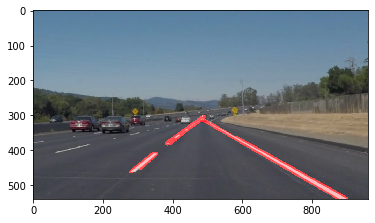

In [22]:
# render the detected lines on the original image

line_image = draw_lines(image, lines) # <---- Add this call.
plt.figure()
plt.imshow(line_image)
plt.show()


In [23]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

In [24]:

min_y = image.shape[0] * (3 / 5) # <-- Just below the horizon
min_y = int(min_y)
max_y = image.shape[0] # <-- The bottom of the image

# The polyfit and poly1d operations can generate a linear function 
# that match the two given spaces (x and y) for each group.
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))
line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]]
    
)

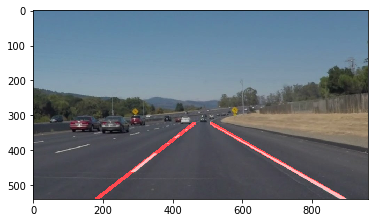

In [25]:
plt.figure()
plt.imshow(line_image)
plt.show()

In [26]:
# printing the left lane and right lane selected from previous task

print(left_x_start ,max_y , left_x_end,min_y)
print(right_x_start, max_y, right_x_end, min_y)

181 540 461 324
893 540 511 324


In [27]:
# make a copy of line image

line_image_copy = np.copy(line_image)

In [28]:
# mask the area between the right and left lane 
# fill the area with blue color

def region_of_interests(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = (0,0,255) # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
region_of_interest_vertices = [
    (left_x_start+10,max_y),
    (left_x_end,min_y),
    (right_x_end,min_y),
    (right_x_start-12,max_y)
]

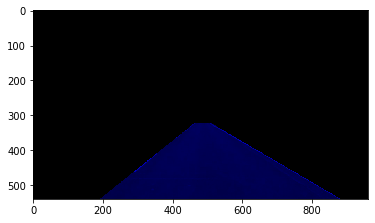

In [29]:
# display the masked image 

crop_image = region_of_interests(
    line_image_copy,
    np.array([region_of_interest_vertices], np.int32)
)
plt.figure()
plt.imshow(crop_image)
plt.show()

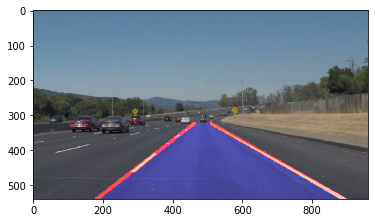

In [31]:
# combine copied image and masked image and display it
complete_img = line_image_copy+crop_image

plt.imshow(complete_img);